In [269]:
import pickle as pkl
import numpy as np
import os

root = '/home/lioruzan/latest_checkpoints2'
runs = [[] for j in range(8)]
for i in range(8):
    if i==6: continue # nothing 
    r = os.path.join(root,'dir%d'%i)
    for j in range(10):
        p = os.path.join(r,'results_{}.pkl'.format(j))
        with open(p,'rb') as f:
            runs[i].append(pkl.load(f))

# format of pickled files: {'gen_data': ( sample_x, x, m, sample_prob, colored_x ), 'size': size}
samps = []
datas = []
masks = []
colrs = []
probs = []
# collect generates samples from all 8 models for each experiment (20 total)
for j in range(10):
    samp = np.zeros((0,32,32,1),dtype=np.float32)
    data = samp.copy()
    mask = samp.copy().astype(np.int32)
    colr = np.zeros((0,32,32,3),dtype=np.float32)
    prob = np.zeros(len(data), dtype=np.float32)
    for i in range(8):
        if i==6: continue
        gen_data = runs[i][j]['gen_data']
        cutoff = runs[i][j]['size']
        total = len(gen_data) * len(gen_data[0][0])
        e = total-cutoff
        c = 1
        for sample_x, x, m, sample_prob, colored_x in gen_data:
            if c == len(gen_data):
                sample_x = sample_x[:-e]
                x = x[:-e]
                m = m[:-e]
                colored_x = colored_x[:-e]
                sample_prob = sample_prob[:-e]
            samp = np.vstack([samp, sample_x])
            data = np.vstack([data, x])
            mask = np.vstack([mask, m])
            colr = np.vstack([colr, colored_x])
            prob = np.concatenate([prob, sample_prob])
            c += 1
    samps.append(samp)
    datas.append(data)
    masks.append(mask)
    colrs.append(colr)
    probs.append(prob)

In [270]:
average_psnrs=[]
std_psnrs=[]
for run in range(10):
    # calculate mean average psnr
    mses = []
    sample_x = samps[run]
    x = datas[run]
    # calculate per-picture psnr vectorized
    #change to 0..255
    a = np.round(127.5 * sample_x + 127.5)
    b = x
    mse = np.sum( np.power(a-b,2), axis=(1,2,3) ) / np.prod( a.shape[1:] ) # ignore batch size
    
    # discard all samples from padding
    
    psnrs = 20 * ( np.log10(255) - np.log10( np.sqrt(mse) ) )
    psnr_avg, psnr_std = np.mean(psnrs), np.std(psnrs)
    print("average psnr run {}: {}, std: {}".format(run, psnr_avg, psnr_std))
    average_psnrs.append(psnr_avg)
    std_psnrs.append(psnr_std)
    
# show stats summary
if len(average_psnrs)>0:
    print("mean average psnr: {}, std over averages: {}, mean psnr std: {}, std over stds: {}".format(
            np.mean(average_psnrs), np.std(average_psnrs),
            np.mean(std_psnrs), np.std(std_psnrs)))

average psnr run 0: 15.596709251403809, std: 5.038705348968506
average psnr run 1: 10.600532531738281, std: 3.953076124191284
average psnr run 2: 12.97390365600586, std: 4.980672836303711
average psnr run 3: 10.64826774597168, std: 4.147854804992676
average psnr run 4: 15.444046974182129, std: 4.20497465133667
average psnr run 5: 10.540068626403809, std: 3.905148506164551
average psnr run 6: 13.508923530578613, std: 5.537979602813721
average psnr run 7: 10.533734321594238, std: 3.7746121883392334
average psnr run 8: 15.397482872009277, std: 4.409556865692139
average psnr run 9: 10.461772918701172, std: 3.9135332107543945
mean average psnr: 12.570544242858887, std over averages: 2.1620352268218994, mean psnr std: 4.386610984802246, std over stds: 0.5667815208435059


In [82]:
sum([len(o) for o in samps]) / 20 == 147

True

In [211]:
len(colrs[0])

29

In [232]:
# reorder full generation to bla bla blla the same
y = get_orientations(masks0[0])

In [236]:
colrs00 = np.zeros((147,32,32,3),dtype=np.float32)
p = 0
for i in range(8):
    if i == 6: continue
    inds = (y==i).nonzero()[0]
    colrs00[p:p+len(inds)] = colrs0[0][inds]
    p += len(inds)
p == 147

True

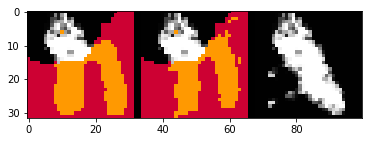

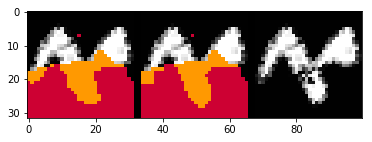

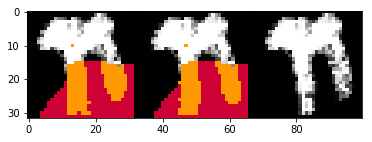

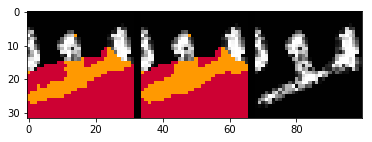

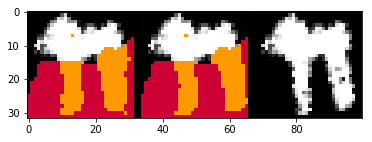

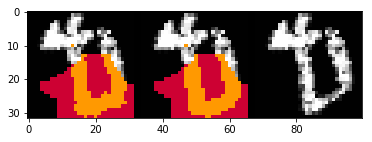

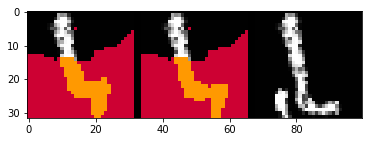

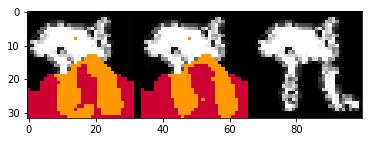

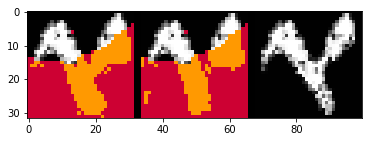

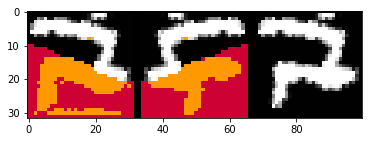

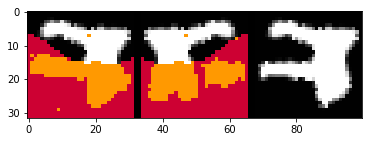

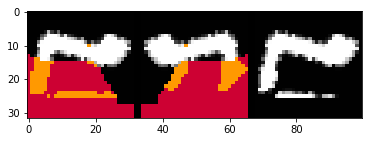

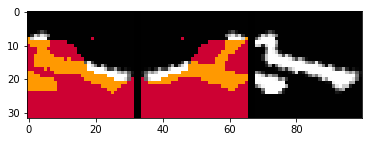

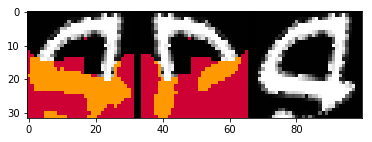

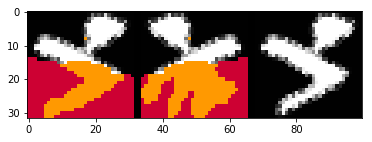

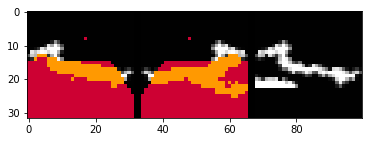

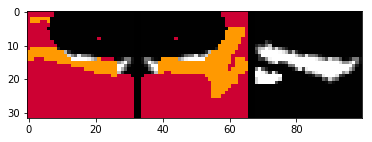

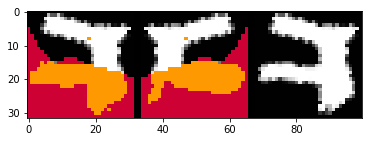

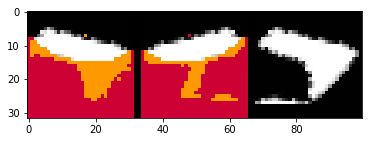

In [284]:
import matplotlib.pyplot as plt
# r = np.random.randperm()
sep = np.zeros((32,2,3),dtype=np.float32)
cc=1
for i in range(20,len(colrs[0])):
    if cc == 20:
        break
    x = (datas[0][i].repeat(3,2)-127.5)/127.5
    im = np.concatenate([colrs[0][i],sep,colrs[1][i],sep,x],axis=1)
    plt.imshow(np.squeeze(im))
    plt.show()
    cc+=1

In [280]:
datas[0][0].min()#*127.5+127.5

0.0

In [ ]:

''' calculate mean average psnr (+- mean average std)'''
average_psnrs, std_psnrs = [], []
for o, data, _ in runss:
    psnrs=[]
    for i in range(o.shape[0]):
        #change to 0..255
        x = np.round(127.5 * o[i] + 127.5)
        y = data[i]
        #mse
        mse = np.sum( np.power(x-y,2) ) / np.prod( x.shape )
        #psnr
        psnr = 20 * ( np.log10(255) - np.log10(np.sqrt(mse)) )
        psnrs.append(psnr)
        
    psnr_avg, psnr_std = np.mean(psnrs), np.std(psnrs)
    average_psnrs.append(psnr_avg)
    std_psnrs.append(psnr_std)
print('{:.5} +-{:.5}'.format(np.mean(average_psnrs), np.mean(std_psnrs)))


In [169]:
''' PARSE DATA '''
import pandas as pd
import os

labels_csv = os.path.join('letters_data', 'labels.csv')
df = pd.read_csv(labels_csv, encoding='ISO-8859-8', header=None)
df = df.applymap(str.strip)

# clean data
doubles = df.applymap(lambda x: True if len(x)>1 and x.find('!') == -1 else False)[1]
X       = df.applymap(lambda x: True if x == 'X' else False)[1]

df = df[~doubles & ~X].reset_index(drop=True)

# label fix ש -> ה
df.iloc[3659][1]='ה!'

root = 'letters_data'
file_list = []
label_list = []
for _,y in df.iterrows():
    file_list.append(os.path.join(root,y[0][1:].replace('\\','/')))
    label_list.append(y[1])

l = sorted(list(set(label_list)))
label_to_idx = {}
for i,j in enumerate(l):
    label_to_idx[j] = i
label_list = [label_to_idx[s] for s in label_list]

In [197]:
''' IMAGE STATS '''
import scipy.misc as sm
import numpy as np

imgs = [sm.imread(file,mode='RGB') for file in file_list]

shapes=[o.shape for o in imgs]
print(np.median(shapes, axis=0), np.mean(shapes, axis=0), np.std(shapes, axis=0))
print(np.max(shapes,axis=0),np.min(shapes,axis=0))
print(np.argmax(shapes, axis=0), np.argmin(shapes,axis=0))

[ 192.  167.    3.] [ 208.19724556  168.49743231    3.        ] [ 47.07156859  29.70098797   0.        ]
[346 231   3] [143 111   3]
[947  86   0] [1566  952    0]


In [190]:
ars = np.array([o[1]/o[0] for o in shapes])
import scipy.stats as st
# st.mode(ars)[2]
np.histogram(ars,bins=10)

(array([ 201,  413,  549,  916, 1150,  553,  240,  206,   50,    6]),
 array([ 0.34124629,  0.46726152,  0.59327675,  0.71929198,  0.84530722,
         0.97132245,  1.09733768,  1.22335291,  1.34936814,  1.47538337,
         1.6013986 ]))

In [196]:
ars=sorted(ars)
for j in ars: print(j)

0.341246290801
0.365325077399
0.373134328358
0.374622356495
0.375404530744
0.380952380952
0.382089552239
0.383561643836
0.384146341463
0.386581469649
0.386627906977
0.387096774194
0.387573964497
0.387959866221
0.388535031847
0.389380530973
0.389380530973
0.39222614841
0.39222614841
0.394039735099
0.398119122257
0.398713826367
0.400621118012
0.403846153846
0.404761904762
0.405660377358
0.405693950178
0.405797101449
0.405882352941
0.407624633431
0.407738095238
0.408823529412
0.409395973154
0.41049382716
0.41134751773
0.411764705882
0.41265060241
0.413793103448
0.415625
0.415807560137
0.41592920354
0.416129032258
0.416666666667
0.418238993711
0.418918918919
0.419642857143
0.419672131148
0.419825072886
0.420074349442
0.42071197411
0.421538461538
0.421686746988
0.422442244224
0.422818791946
0.424242424242
0.424354243542
0.424836601307
0.425
0.425219941349
0.425605536332
0.425655976676
0.426035502959
0.427184466019
0.427272727273
0.42750929368
0.427609427609
0.428571428571
0.428571428571
0.4

In [3]:
for m in test_letters['masks']:
    sm.imshow(m*255)
    break

In [20]:
len(test_letters['masks'])

147

In [28]:
''' MAKE IMAGES '''
import scipy.misc as sm
import numpy as np

imgs = [sm.imread(file,mode='RGB') for file in file_list]

# resized_imgs = [sm.imresize(im,(32,32)) for im in imgs]

# resized_imgs = [im[np.newaxis,:,:,:] for im in resized_imgs]
# images = np.vstack(resized_imgs)
# labels = np.array(label_list)

[ 192.  167.    3.] [ 47.07156859  29.70098797   0.        ]


In [29]:
''' IMAGE STATS '''
shapes=[o.shape for o in imgs]
print(np.median(shapes, axis=0), np.mean(shapes, axis=0), np.std(shapes, axis=0))
print(np.max(shapes,axis=0),np.min(shapes,axis=0))
print(np.argmax(shapes, axis=0), np.argmin(shapes,axis=0))

[ 192.  167.    3.] [ 208.19724556  168.49743231    3.        ] [ 47.07156859  29.70098797   0.        ]


In [74]:
''' stitch together 4-model adaptive rotation results '''

root = '/home/lioruzan/pixel-cnn/data/letters_data/checkpoints'
runs= [[] for j in range(4)]
for i in range(4):
    r = os.path.join(root,str(i))
    for j in range(10):
        p = os.path.join(r,'results_{}.pkl'.format(j))
        with open(p,'rb') as f:
            runs[i].append(pkl.load(f))
            

runss=[]
for j in range(10):
    samp=np.zeros((0,32,32,3))
    data=samp.copy()
    mask=data.copy()
    for i in range(4):
        for sample,(x,m) in runs[i][j]:
            sample = np.rot90(sample, k=-i, axes=(1,2))
            x = np.rot90(x, k=-i, axes=(1,2))
            m = np.rot90(m, k=-i, axes=(1,2))
            samp = np.vstack([samp,sample])
            data = np.vstack([data,x])
            mask = np.vstack([mask,m])
    runss.append((samp,data,mask))

''' calculate mean average psnr (+- mean average std)'''
average_psnrs, std_psnrs = [], []
for o, data, _ in runss:
    psnrs=[]
    for i in range(o.shape[0]):
        #change to 0..255
        x = 127.5 * o[i] + 127.5
        y = data[i]
        #mse
        mse = np.sum( np.power(x-y,2) ) / np.prod( x.shape )
        #psnr
        psnr = 20 * ( np.log10(255) - np.log10(np.sqrt(mse)) )
        psnrs.append(psnr)
        
    psnr_avg, psnr_std = np.mean(psnrs), np.std(psnrs)
    average_psnrs.append(psnr_avg)
    std_psnrs.append(psnr_std)
print('{:.5} +-{:.5}'.format(np.mean(average_psnrs), np.mean(std_psnrs)))

''' visualize results '''
p=np.random.randint(140)
plt.imshow(runss[0][1][p]/127.5-1)
plt.show()
plt.imshow((runss[0][1][p]/127.5-1)*runss[0][2][p])
plt.show()
plt.imshow(runss[0][0][p])
plt.show()

In [166]:
psnrs

[8.0094482437804793,
 11.576742746439566,
 14.397416623109148,
 16.050003389271453,
 13.547408969241141,
 23.056076520934205,
 12.633913553358219,
 10.246024123511299,
 15.334448796610154,
 11.782192016462133,
 17.510175958815275,
 14.843173007889474,
 16.122954277595923,
 9.2200377348149019,
 11.28626104247334,
 13.515986057497367,
 12.148469563477926,
 9.8219308970910735,
 8.7616479031172201,
 9.9355380158090778,
 19.154202360878038,
 9.3201170342204023,
 16.84945659447223,
 8.0179964062435083,
 45.277232672125834,
 16.739734812845398,
 17.787932509869016,
 14.943535805970427,
 17.171969258429161,
 16.404846435637506,
 9.6479973378444903,
 18.378914848942021,
 15.494049563983769,
 10.581258431914232,
 10.126872069824966,
 16.304898685291889,
 10.819779646181988,
 14.685991622401652,
 15.172440514593362,
 12.363724994144203,
 18.359321153140389,
 20.18213067097788,
 14.180420893095897,
 8.9782805376706776,
 16.63958832636947,
 12.905960815126329,
 13.885445578248623,
 9.83530878940037

In [158]:
import scipy.ndimage.measurements as me
def get_orientations(ms):
    o = np.zeros(len(ms), dtype=np.int32) # orientations
    for i, m in enumerate(ms):
        m = m[:,:,0]
        y,x = me.center_of_mass(m)
        if np.isnan(x) or np.isnan(y): 
            continue
        # center coordinates
        y -= 15.5
        x -= 15.5
        # fill o with optimal orientation for each mask, to maximize exposure
        # of known information (1s in the mask) to PixelCNN
        if y>=0 and x>=0:
            if y>x:
                o[i] = 2 # 2 rotations
            elif y<=x:
                o[i] = 7 # flip + 3 rotations
        elif y>=0 and x<0:
            if y>=-x:
                o[i] = 6 # flip + 2 rotations
            elif y<-x:
                o[i] = 3 # 3 rotations
        elif y<0 and x<0:
            if y>=x:
                o[i] = 5 # flip + 1 rotations
            elif y<x:
                o[i] = 0 # no flips or rotations, this is optimal
        elif y<0 and x>=0:
            if y>=-x:
                o[i] = 1 # one rotation
            if y<-x:
                o[i] = 4 # just flip no rotation needed
    return o

def flip_rotate(x, y):
    '''
    flips and/or rotates a single image according to label y
    y is encoded to represent flips and rotations
    y \in {0..7} or y \in {-7..-1} for reversing rotations\flips
    flip indicator = y // 4 ( or y <= -4 in the negative case )
    rotation angle = (y % 4) * 90 degrees
    because of dihedral group D4 structure, in some cases the order of flip/rotation
    matters, and is dealt with accordingly.
    '''
    if y // 4 == 1 or y == -4 or y == -6:
        x = np.flip(x, len(x.shape)-2)
    if len(x.shape) == 4:
        x = np.rot90(x, k= y % 4, axes=(1,2))
    else:
        x = np.rot90(x, k= y % 4)
    if y == -5 or y == -7:
        x = np.flip(x, len(x.shape)-2)
    return x

In [130]:
import pickle as pkl
with open('./letters_data/letters_test.pkl', 'rb') as f:
    q=pkl.load(f)

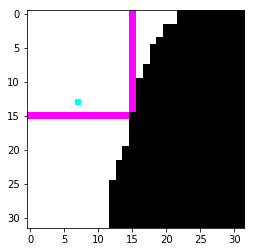

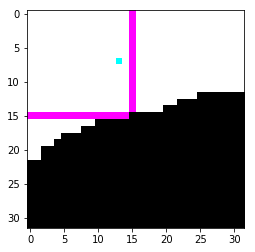

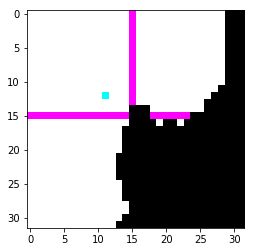

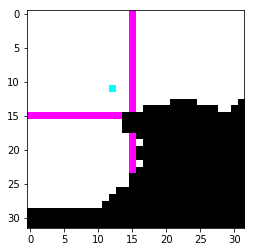

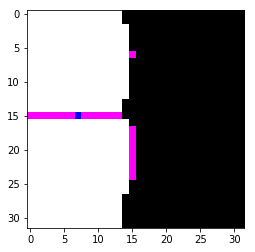

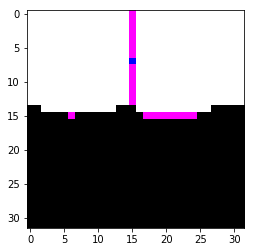

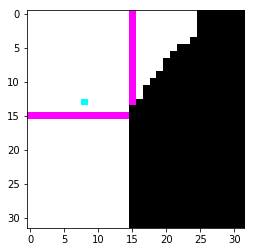

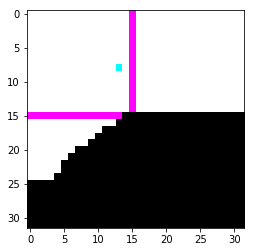

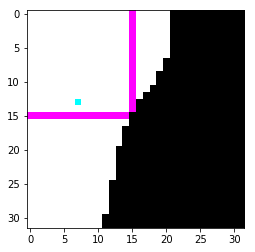

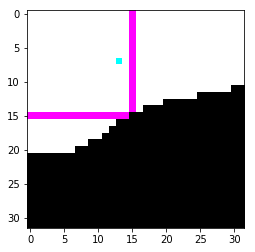

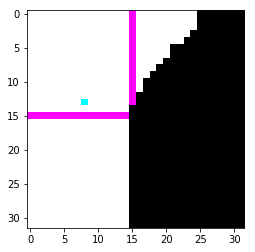

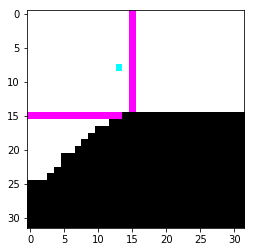

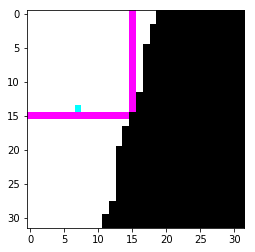

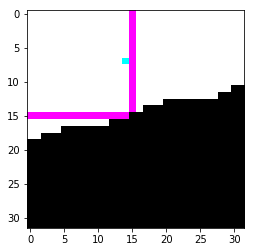

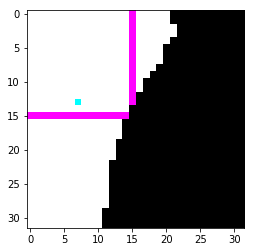

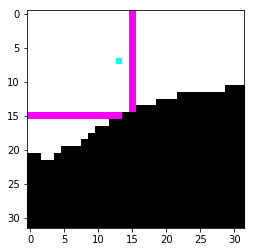

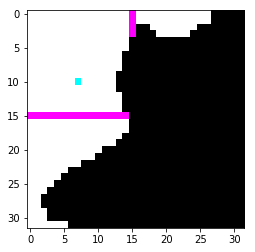

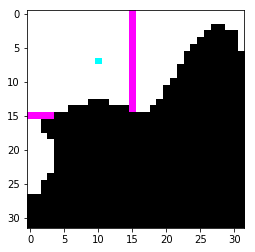

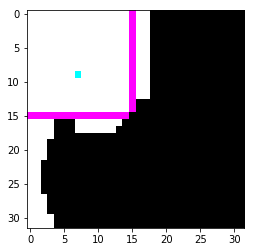

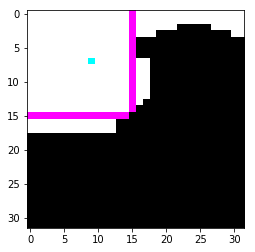

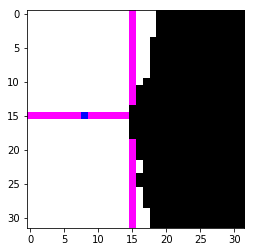

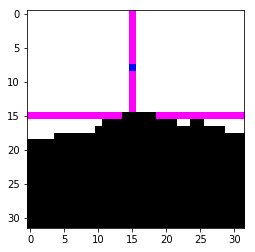

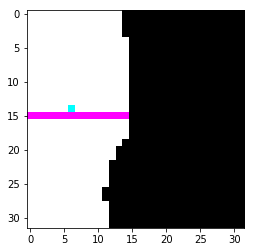

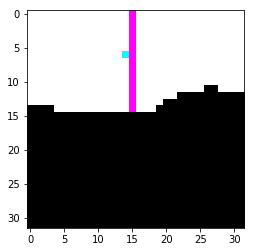

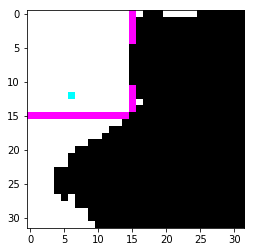

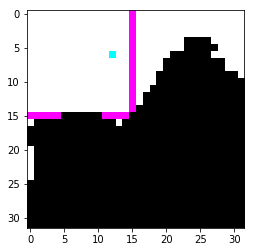

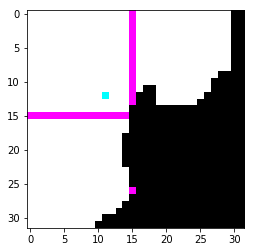

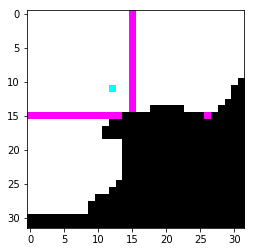

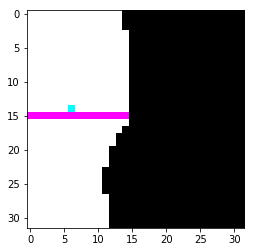

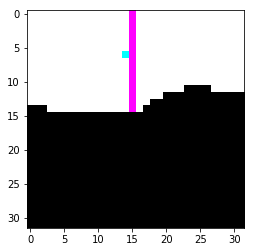

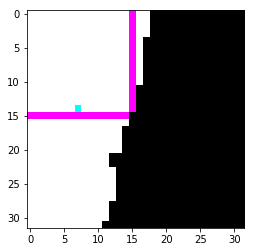

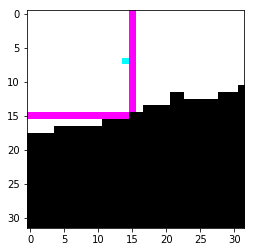

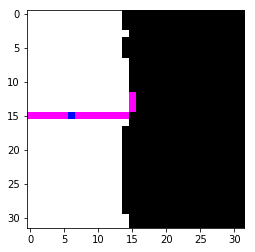

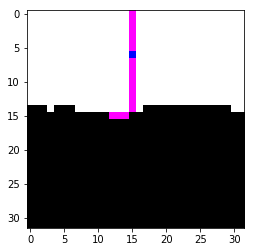

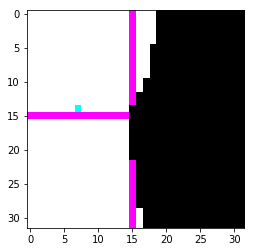

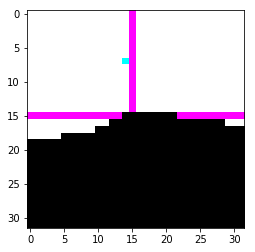

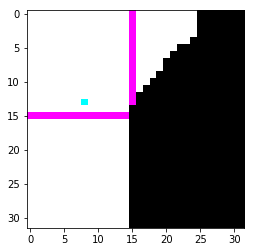

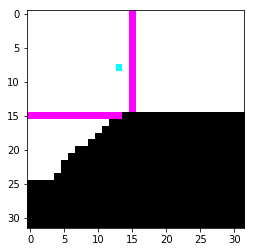

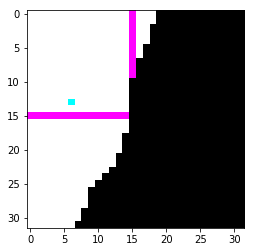

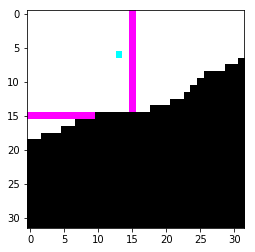

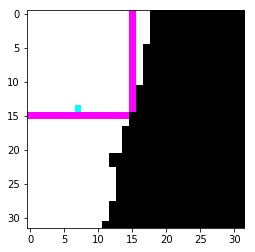

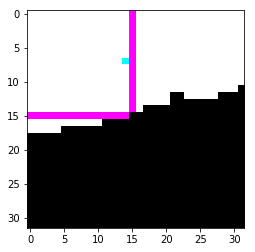

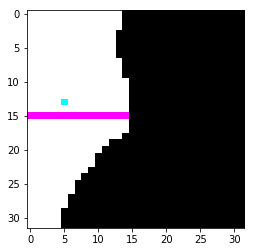

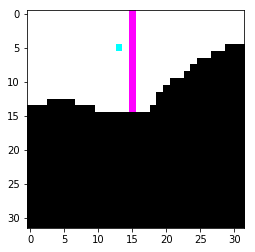

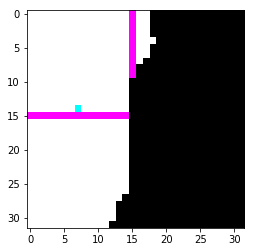

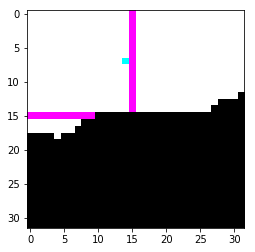

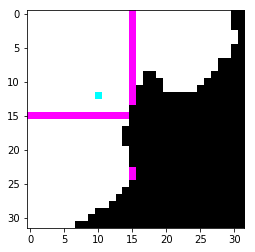

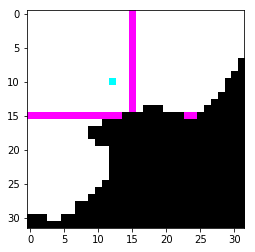

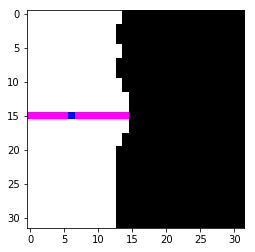

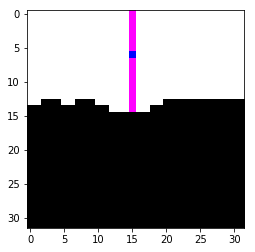

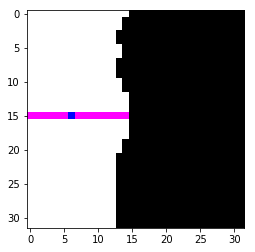

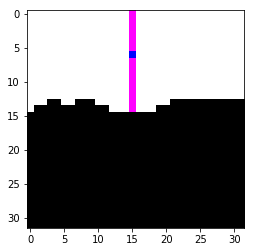

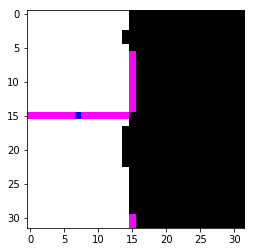

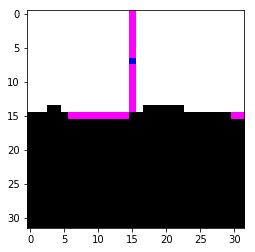

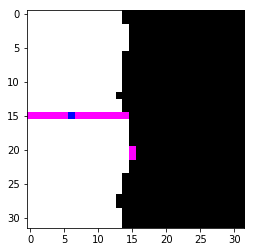

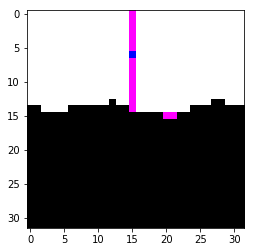

In [187]:
ms = q['masks']

y = get_orientations(ms)



for j in (y==5).nonzero()[0]:
    
    m=ms[j]*255
    mf=flip_rotate(ms[j],y[j])*255

    ym,xm = me.center_of_mass(m[...,0])
    ym,xm=int(ym),int(xm)
    m[ym,xm,0]=0
    m[:,15,1]=0
    m[15,:,1]=0
    ymf,xmf = me.center_of_mass(mf[...,0])
    ymf,xmf=int(ymf),int(xmf)
    mf[ymf,xmf,0]=0
    mf[:,15,1]=0
    mf[15,:,1]=0
    plt.imshow(m)
    plt.show()
    plt.imshow(mf)
    plt.show()